# HyDE

https://ar5iv.labs.arxiv.org/html/2212.10496

In [1]:
from datasets import load_dataset
import pandas as pd
import torch

mps_device = torch.device("mps")

dataset = load_dataset("msaad02/categorized-data", split="train")
category_df = dataset.to_pandas()

qa_df = pd.concat([
    load_dataset("msaad02/brockport-gpt-4-qa", split="train").to_pandas(),
    load_dataset("msaad02/brockport-gpt-3.5-qa", split="train").to_pandas()
])

df = pd.merge(qa_df, category_df[["url", "category", "subcategory"]], on="url", how="left")

train_df = df.groupby("category").sample(n=4000, replace=True)
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(lowercase=True, min_df=5)

train_vect = vectorizer.fit_transform(train_df['question'])

In [3]:
text_to_int = {text: idx for idx, text in enumerate(train_df['category'].unique())}
int_to_text = {idx: text for text, idx in text_to_int.items()}

train_df['category_vect'] = train_df['category'].apply(lambda x: text_to_int[x])

In [4]:
train_proportion = 0.8
validation_prop = 0.1
train_size = int(train_proportion * train_vect.shape[0])
validation_size = int(validation_prop * train_vect.shape[0])

X_train = torch.tensor(train_vect[:train_size].toarray(), dtype=torch.float32, device=mps_device)
y_train = torch.tensor(train_df['category_vect'][:train_size].to_numpy(), dtype=torch.long, device=mps_device)
X_val = torch.tensor(train_vect[train_size:train_size+validation_size].toarray(), dtype=torch.float32, device=mps_device)
y_val = torch.tensor(train_df['category_vect'][train_size:train_size+validation_size].to_numpy(), dtype=torch.long, device=mps_device)
X_test = torch.tensor(train_vect[train_size+validation_size:].toarray(), dtype=torch.float32, device=mps_device)
y_test = torch.tensor(train_df['category_vect'][train_size+validation_size:].to_numpy(), dtype=torch.long, device=mps_device)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, device=mps_device) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes, device=mps_device)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [5]:
 
# Hyper-parameters
input_size = X_train.shape[1]
hidden_size = 10000
num_classes = train_df['category'].unique().__len__()
num_epochs = 120

# Instantiate the model, optimizer, and loss function
model = SimpleNN(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

train_losses = []
validation_losses = []

# Train the model
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Validation loss
    validation_loss = criterion(model(X_val), y_val)

    train_losses.append(loss.cpu().detach().numpy())
    validation_losses.append(validation_loss.cpu().detach().numpy())

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {validation_loss.item():.4f}')

Epoch [10/120], Loss: 1.9350, Validation Loss: 1.9432
Epoch [20/120], Loss: 0.9987, Validation Loss: 1.0275
Epoch [30/120], Loss: 0.5593, Validation Loss: 0.6162
Epoch [40/120], Loss: 0.3834, Validation Loss: 0.4702
Epoch [50/120], Loss: 0.2958, Validation Loss: 0.4053
Epoch [60/120], Loss: 0.2467, Validation Loss: 0.3727
Epoch [70/120], Loss: 0.2152, Validation Loss: 0.3556
Epoch [80/120], Loss: 0.1925, Validation Loss: 0.3460
Epoch [90/120], Loss: 0.1731, Validation Loss: 0.3407
Epoch [100/120], Loss: 0.1548, Validation Loss: 0.3376
Epoch [110/120], Loss: 0.1418, Validation Loss: 0.3357
Epoch [120/120], Loss: 0.1329, Validation Loss: 0.3362


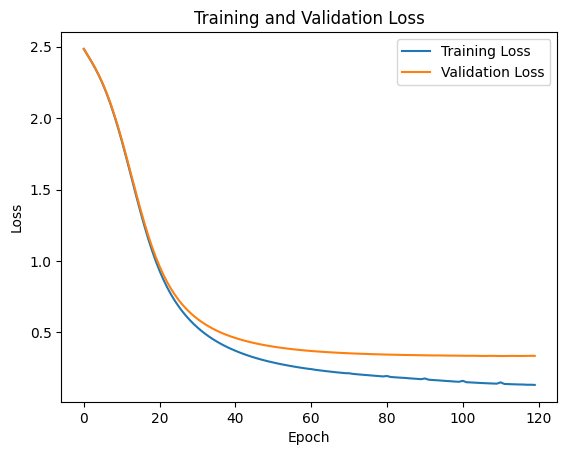

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the training and validation loss
plt.plot(np.array(train_losses), label='Training Loss')
plt.plot(np.array(validation_losses), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [7]:
# Find the paramter count of the model
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')

34,530,012 total parameters.


In [8]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

# Evaluate the model on the test data
with torch.no_grad():
    model.eval()
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)

# Calculate accuracy
accuracy = accuracy_score(y_test.cpu(), predicted.cpu())
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test.cpu(), predicted.cpu())
print("Confusion Matrix:")
print(confusion_mat)

Accuracy: 92.02%
Confusion Matrix:
[[382   1   3   0   1   0   1   5   0   2   1   0]
 [  1 305   6   5  12   3   0   6   2  14  13  23]
 [  0   0 373   7   0   0   0   9   0   0   5   0]
 [  0   2   0 389   0   0   0   5   0   0   0   0]
 [  0   4   0   1 368   2   1   4   0   3   2   5]
 [  0   0   0   2   0 373   0  19   0   0   0   0]
 [  0   0   0   0   0   0 436   0   0   0   0   0]
 [  0   0   2   5   0   4   0 404   0   0   6   0]
 [  0   0   0   0   0   0   0   0 403   0   0   0]
 [  1  13   4   0   7   2   0  15   1 320   7  12]
 [  4  18   9   4   7   3   0  24   0   9 331   5]
 [  1  22   2   4   4   1   0   3   2   2  10 333]]


In [9]:
import json
def predict_category(question: str):
    question_vect = vectorizer.transform([question])
    question_vect = torch.tensor(question_vect.toarray(), dtype=torch.float32, device=mps_device)
    with torch.no_grad():
        model.eval()
        outputs = model(question_vect)
        _, predicted = torch.max(outputs.data, 1)

    label_softmax = torch.softmax(outputs, dim=1).cpu().detach().numpy()[0]
    probability_dict = {int_to_text[idx]: round(prob*100, 2) for idx, prob in enumerate(label_softmax)}

    return_string = f"""\
    Predicted Category: {int_to_text[predicted.cpu().item()]}

    Probability Distribution:
    {json.dumps(probability_dict, indent=4)}
    """
    return return_string

In [10]:
import gradio as gr

demo = gr.Interface(fn=predict_category, inputs="text", outputs="text")
    
if __name__ == "__main__":
    demo.launch(show_api=False)   

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


# Classification Class

Creating a class instance so we can serialize it to a file with pickle and load it in later.

In [3]:
import torch.nn as nn
import sklearn

class CategoryClassifier():
    def __init__(
            self, 
            model: nn.Module, 
            vectorizer: sklearn.feature_extraction.text.CountVectorizer, 
            int_to_text: dict,
            device: str = "cpu"
        ):
        assert device in ['cuda', 'cpu', 'mps']
        self.device = torch.device(device)
        model.to(device)
        self.model = model
        self.vectorizer = vectorizer
        self.int_to_text = int_to_text

    def predict_category(
            self, 
            question: str, 
            return_probs: bool = False
        ):
        "Predict the category of a question"
        question_vect = self.vectorizer.transform([question])
        question_vect = torch.tensor(question_vect.toarray(), dtype=torch.float32, device=self.device)
        with torch.no_grad():
            self.model.eval()
            outputs = self.model(question_vect)
            _, predicted = torch.max(outputs.data, 1)

        class_pred = int_to_text[predicted.cpu().item()]

        label_softmax = torch.softmax(outputs, dim=1).cpu().detach().numpy()[0]
        probabilities = {int_to_text[idx]: round(prob*100, 2) for idx, prob in enumerate(label_softmax)}

        if return_probs:
            return class_pred, probabilities
        else:
            return class_pred
    
# classifier = CategoryClassifier(model, vectorizer, int_to_text, device="mps")

In [38]:
classifier.predict_category("here is a question")

'live'

In [39]:
import pickle

In [40]:
pickle.dump(classifier, open('classifier.pkl', 'wb'))

In [8]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer

classifier = pickle.load(open('classifier.pkl', 'rb'))

classifier.predict_category("here is a question")

NameError: name 'int_to_text' is not defined